# Learn Recurrence

In [2]:
from collections import namedtuple, OrderedDict
import os

import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
from nengo.utils.ensemble import tuning_curves
import nengolib
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import (numpy_bytes_to_str, norm_spa_vecs, BasicVecFeed)
from nengo_learn_assoc_mem.paths import data_path

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Setup

In [25]:
neg_voja_lr = 5e-6
intercept = 0.1
n_repeats = 4

load_path = os.path.join(data_path, "neg_voja_enc", f"neg_voja_enc_{n_repeats}_{intercept}_{neg_voja_lr}.h5")

In [26]:
with h5py.File(load_path, "r") as fi:
    print(list(fi.keys()))

    fan1 = numpy_bytes_to_str(fi['fan1'])
    fan2 = numpy_bytes_to_str(fi['fan2'])
    foil1 = numpy_bytes_to_str(fi['foil1'])
    foil2 = numpy_bytes_to_str(fi['foil2'])

    v_strs = numpy_bytes_to_str(fi['vocab_strings'])
    v_vecs = list(fi['vocab_vectors'])
    dimensions = fi['vocab_vectors'].attrs['dimensions']

    n_neurons = fi['encoders'].shape[1]
    seed = fi['encoders'].attrs['seed']

    dt = fi['t_range'].attrs['dt']

['encoders', 'fan1', 'fan2', 'foil1', 'foil2', 'response', 't_range', 'vocab_strings', 'vocab_vectors']


In [27]:
vocab = spa.Vocabulary(dimensions)
for val, vec in zip(v_strs, v_vecs):
    vocab.add(val, vec)

fan1_pair_vecs = norm_spa_vecs(vocab, fan1)
fan2_pair_vecs = norm_spa_vecs(vocab, fan2)
foil1_pair_vecs = norm_spa_vecs(vocab, foil1)
foil2_pair_vecs = norm_spa_vecs(vocab, foil2)

In [28]:
t_pause = 0.5
t_present = 0.3

t_each = t_pause + t_present
td_each = int(t_each/dt)
td_pause = int(t_pause/dt)

In [29]:
fan1_slc = slice(td_pause, td_each*len(fan1_pair_vecs)+td_pause)
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+td_each*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+td_each*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+td_each*len(foil2_pair_vecs))

In [30]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'vecs', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, np.array(fan1_pair_vecs), fan1_slc),
                 "fan2": SlcStim(2, True, np.array(fan2_pair_vecs), fan2_slc),
                 "foil1": SlcStim(1, False, np.array(foil1_pair_vecs), foil1_slc),
                 "foil2": SlcStim(2, False, np.array(foil2_pair_vecs), foil2_slc)}

In [31]:
def calc_weights(fin_enc: np.ndarray, cepts: np.ndarray,
                 base_inhib_mag: float, min_pos_w: float, max_pos_w: float) -> np.ndarray:
    with nengolib.Network(seed=seed) as model:
        ens = nengo.Ensemble(n_neurons, dimensions, encoders=fin_enc.copy(), intercepts=cepts, seed=seed)

    with nengo.Simulator(model) as sim:
        pass
    
    feed_vecs = fan1_pair_vecs + fan2_pair_vecs
    _, activities = tuning_curves(ens, sim, inputs=np.array(feed_vecs))
    
    mean_act = np.mean(activities, axis=0)
    act_corr = np.zeros((n_neurons, n_neurons), dtype=np.float)

    for v_i in range(len(feed_vecs)):
        act_corr += np.outer(activities[v_i]-mean_act, activities[v_i])
    np.fill_diagonal(act_corr, 0)
    
    max_corr = np.max(act_corr)
    min_corr = np.min(act_corr)
    
    pos_corr = act_corr[act_corr > 0.]
    min_pos_corr = np.min(pos_corr)
    neg_corr = act_corr[act_corr < 0.]
    max_neg_corr = np.max(neg_corr)
    
    rec_w = np.ones((n_neurons, n_neurons), dtype=np.float) * base_inhib_mag
    rec_w[act_corr > 0.] = np.interp(pos_corr,
                                     (min_pos_corr, max_corr),
                                     (base_inhib_mag, max_pos_w)) 
    rec_w[act_corr < 0.] = np.interp(neg_corr,
                                     (min_corr, max_neg_corr),
                                     (min_pos_w, base_inhib_mag)) 
    np.fill_diagonal(rec_w, 0)
    
    return rec_w

In [32]:
def weight_eval(fin_enc: np.ndarray, cepts: np.ndarray,
                rec_weights: np.ndarray, rec_synapse=0.01):
    feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs
    
    feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

    with nengolib.Network(seed=seed) as learned_model:
        in_nd = nengo.Node(feed.feed)
        pause = nengo.Node(lambda t: feed.paused)
        meg_node = nengo.Node(lambda t, x: np.sum(x), size_in=n_neurons, size_out=1)

        ens = nengo.Ensemble(n_neurons, dimensions,
                             encoders=fin_enc.copy(), intercepts=cepts, seed=seed)

        nengo.Connection(in_nd, ens, synapse=None)
        nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)
        nengo.Connection(ens.neurons, ens.neurons, transform=rec_weights, synapse=rec_synapse)
        nengo.Connection(ens.neurons, meg_node, synapse=None)

        p_in = nengo.Probe(in_nd)
        p_meg = nengo.Probe(meg_node, synapse=0.05)

    with nengo.Simulator(learned_model) as learned_sim:
        learned_sim.run(len(feed_vecs)*t_each + t_pause)
        
    return learned_sim.trange(), learned_sim.data[p_meg].flatten()

In [33]:
def plt_meg(t_range, meg_res):
    df_list = []

    for key, obj in slc_stim_vecs.items():
        act = meg_res[obj.slc]
        resp = [obj.fan_num] * len(act)
        targ = [obj.targ] * len(act)
        df_list.append(pd.DataFrame({"act": act, "resp": resp, "targ": targ}))

    act_df = pd.concat(df_list)
    
    plt.figure()
    ax = sns.barplot(x="resp", y="act", hue="targ", data=act_df)

    ax.set_title("Difference between FAN1 and FAN2 firing rates")
    ax.set_ylabel("Mean Firing Rate")
    ax.set_xlabel("FAN type")

    ax.legend_.set_title("Target vs. Foil")
    ax.legend_.set_bbox_to_anchor((1, 0.8))
    new_labels = ("Foil", "Target")
    for t, l in zip(ax.legend_.texts, new_labels): t.set_text(l)
    
    plt.figure(figsize=(12, 3))
    plt.plot(t_range[fan1_slc], meg_res[fan1_slc], linestyle=":")
    plt.plot(t_range[fan2_slc], meg_res[fan2_slc], linestyle=":")
    
    plt.figure(figsize=(12, 3))
    plt.plot(t_range[foil1_slc], meg_res[foil1_slc], linestyle=":")
    plt.plot(t_range[foil2_slc], meg_res[foil2_slc], linestyle=":")
    
    return act_df

In [34]:
def eval_meg(fin_enc: np.ndarray, rec_weights: np.ndarray, cepts: np.ndarray, rec_synapse=0.01):
    t_range, meg_res = weight_eval(fin_enc, cepts, rec_weights, rec_synapse)
    
    plt_meg(t_range, meg_res)

## Evaluate different recurrence

In [17]:
neg_voja_lr = 5e-6
intercept = 0.1
n_repeats = 4

load_path = os.path.join(data_path, "neg_voja_enc", f"neg_voja_enc_{n_repeats}_{intercept}_{neg_voja_lr}.h5")

In [18]:
with h5py.File(load_path, "r") as fi:
    
    encoders = np.array(fi['encoders'])
    intercepts = [fi['encoders'].attrs['intercept']] * n_neurons

print(intercepts[0])

In [43]:
baseline = -4e-5
max_excite = 1e-4
max_inhib = -4e-3

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

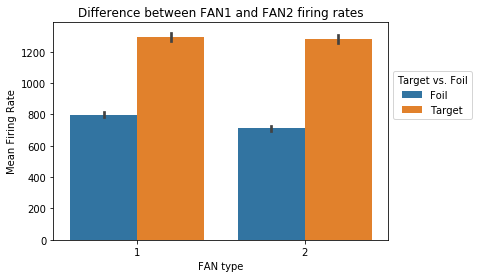

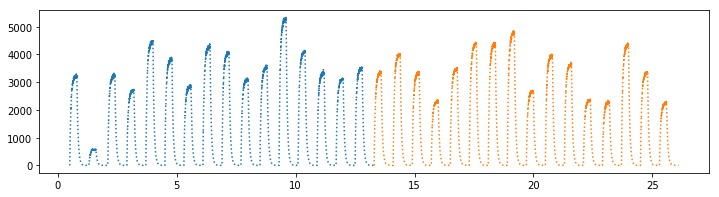

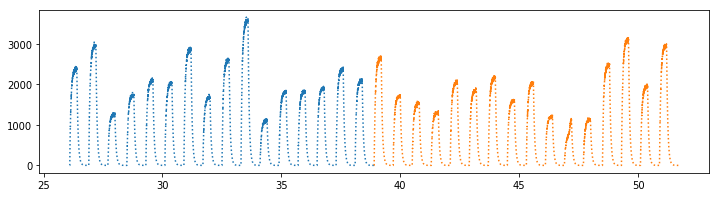

In [45]:
enc = encoders[-1]
rec_w = calc_weights(enc, intercepts, baseline, max_inhib, max_excite)
t_range, pos_comb_meg = weight_eval(enc, intercepts, rec_w, 0.01)

df = plt_meg(t_range, pos_comb_meg)

In [46]:
fan1_resp = pos_comb_meg[fan1_slc].reshape((-1, td_each))
fan2_resp = pos_comb_meg[fan2_slc].reshape((-1, td_each))
foil1_resp = pos_comb_meg[foil1_slc].reshape((-1, td_each))
foil2_resp = pos_comb_meg[foil2_slc].reshape((-1, td_each))

/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


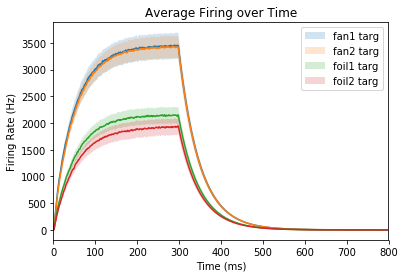

In [47]:
sns.tsplot(fan1_resp, color="C0")
sns.tsplot(fan2_resp, color="C1")
sns.tsplot(foil1_resp, color="C2")
sns.tsplot(foil2_resp, color="C3")

plt.title("Average Firing over Time")
plt.legend(["fan1 targ", "fan2 targ", "foil1 targ", "foil2 targ"], facecolor=None)
plt.ylabel("Firing Rate (Hz)")
plt.xlabel("Time (ms)");

In [48]:
with h5py.File(os.path.join(data_path, "low_intercept_match_weights.h5"), "w") as fi:
    ww = fi.create_dataset("weights", data=rec_w)
    ww.attrs["excite"] = max_excite
    ww.attrs["inhib"] = max_inhib
    ww.attrs["base_inhib"] = baseline

In [35]:
neg_voja_lr = 8e-6 # the range of valid learning rates is (1e-5, 9e-6). WHAT?
intercept = 0.15
n_repeats = 4

load_path = os.path.join(data_path, "neg_voja_enc", f"neg_voja_enc_{n_repeats}_{intercept}_{neg_voja_lr}.h5")

In [36]:
with h5py.File(load_path, "r") as fi:
    
    enc = np.array(fi['encoders'])[-1]
    intercepts = [fi['encoders'].attrs['intercept']] * n_neurons

In [37]:
baseline = 0.
max_excite = 1e-5
max_inhib = -1e-5

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

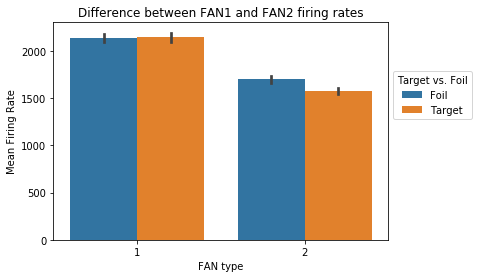

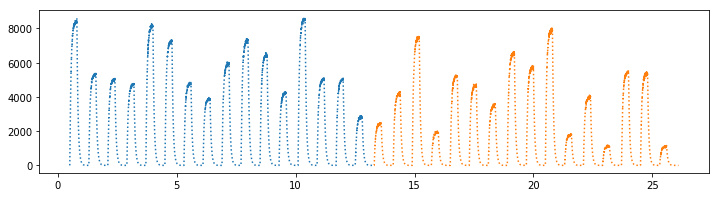

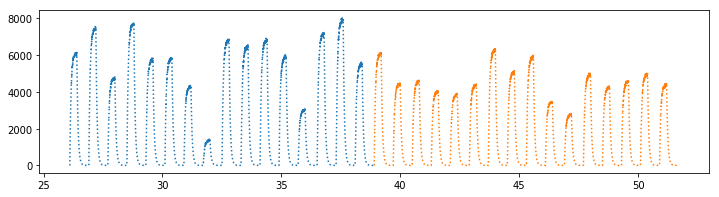

In [38]:
rec_w = np.zeros((n_neurons, n_neurons))#calc_weights(enc, intercepts, baseline, max_inhib, max_excite)
t_range, pos_comb_meg = weight_eval(enc, intercepts, rec_w, 0.01)

df = plt_meg(t_range, pos_comb_meg)

In [22]:
fan1_resp = pos_comb_meg[fan1_slc].reshape((-1, td_each))
fan2_resp = pos_comb_meg[fan2_slc].reshape((-1, td_each))
foil1_resp = pos_comb_meg[foil1_slc].reshape((-1, td_each))
foil2_resp = pos_comb_meg[foil2_slc].reshape((-1, td_each))

/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


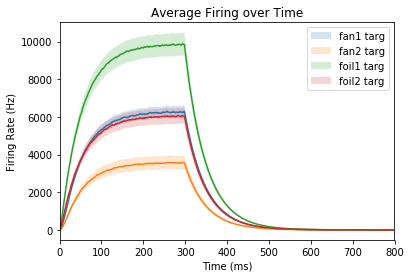

In [23]:
sns.tsplot(fan1_resp, color="C0")
sns.tsplot(fan2_resp, color="C1")
sns.tsplot(foil1_resp, color="C2")
sns.tsplot(foil2_resp, color="C3")

plt.title("Average Firing over Time")
plt.legend(["fan1 targ", "fan2 targ", "foil1 targ", "foil2 targ"], facecolor=None)
plt.ylabel("Firing Rate (Hz)")
plt.xlabel("Time (ms)");

In [31]:
with h5py.File(os.path.join(data_path, "awk_intercept_match_weights.h5"), "w") as fi:
    ww = fi.create_dataset("weights", data=rec_w)
    ww.attrs["excite"] = max_excite
    ww.attrs["inhib"] = max_inhib
    ww.attrs["base_inhib"] = baseline